In [1]:
using Plots, DifferentialEquations,Interpolations, Random, Distributions, NLopt, Dierckx,LaTeXStrings
gr()

Plots.GRBackend()

In [2]:
a=zeros(3)
J=1.0; D=1.0; k=1/10;
α = J/sqrt(D*k); β=sqrt(k/D); σ=1.0/2;
x=LinRange(0,20,21); 
xx=LinRange(0,20,201);

In [3]:
function model(x,a)
y=zeros(length(x))
c(x) = a[1]*exp(-x*a[2])
    for i in 1:length(x) 
    y[i] = c(x[i])
    end 
return y
end

model (generic function with 1 method)

In [4]:
data=[ 3.898952675812746  
2.569825438525737  
1.206631819080483  
1.3543817108830818 
0.6175527058221386 
0.30785528929186456
0.13649714414672498
0.6921031114954066 
0.271392505145547  
0.0945662375934022 
0.06039757137011752
0.1338145218277993 
0.1529291485263356
0.05189445084962129
0.02756210195622014
0.018066943988933968
0.017710583152626524
0.009164129234587067
0.008075081582671598
0.010557776318846062
0.004853780605374777];

In [5]:
function loglhood(data,a,σ)
    y=zeros(length(x))
    y=model(x,a) # simulate deterministic model with parameters a
    ℓ=0;
    data_dists=[LogNormal(0,σ) for mi in y]; # LogNormal distribution
    ℓ+=sum([loglikelihood(data_dists[i],data[i]./y[i]) for i in 1:length(data_dists)])  
    return ℓ
end

loglhood (generic function with 1 method)

In [6]:
a=zeros(2)
function funmle(a)
return loglhood(data,a,σ)
end

funmle (generic function with 1 method)

In [7]:
function Optimise(fun,θ₀,lb,ub)
    tomax=(θ,∂θ)->fun(θ)
    opt=Opt(:LN_NELDERMEAD,length(θ₀))
    opt.max_objective=tomax
    opt.lower_bounds=lb      
    opt.upper_bounds=ub
    opt.maxtime=1*60
    res = optimize(opt,θ₀)
    return res[[2,1]]
end

Optimise (generic function with 1 method)

In [8]:
θG=[α, β]
lb=[0,0]
ub=[1000,1000]
@time (xopt,fopt)=Optimise(funmle,θG,lb,ub)
αmle=xopt[1]
βmle=xopt[2]
fmle=fopt
cmle(x) = xopt[1]*exp(-x*xopt[2]) 

  1.204142 seconds (1.52 M allocations: 82.612 MiB, 38.12% gc time, 99.63% compilation time)


cmle (generic function with 1 method)

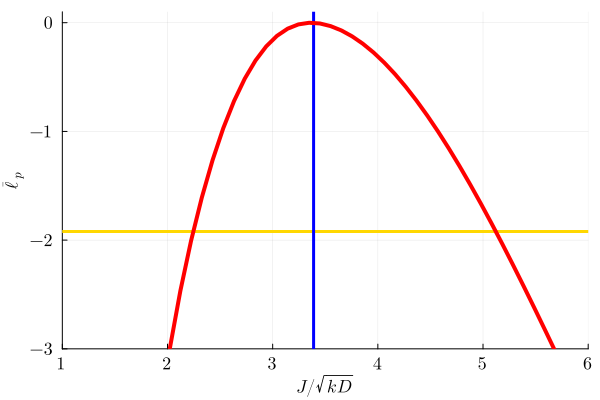

In [11]:
df=1
llstar=-quantile(Chisq(df),0.95)/2

function univariateα(α)
    a=zeros(1)    
    function funα(a)
    return loglhood(data,[α,a[1]],σ)
    end
    θG=[βmle]
    lb=[0.0] 
    ub=[1000.0] 
    (xopt,fopt)=Optimise(funα,θG,lb,ub)
    return fopt,xopt
    end 
    f(x) = univariateα(x)[1]

#Take a grid of M points to plot the univariate profile likelihood
M=50;
αrange=LinRange(1,6,M)
ff=zeros(M)
for i in 1:M
    ff[i]=univariateα(αrange[i])[1]
end


q1=hline([llstar],legend=false,lw=3,xlabel=L"J/\sqrt{kD} ",ylabel=L"\bar{\ell}_p",color=:gold)
q1=vline!([αmle],legend=false,lw=3,color=:blue)
spl=Spline1D(αrange,ff.-maximum(ff),w=ones(length(αrange)),k=3,bc="nearest",s=1/100)
yy=evaluate(spl,αrange)
q1=plot!(αrange,yy,lw=4,lc=:red,ylims=(-3,0.1),xlims=(αrange[1],αrange[end]))
q1=plot!(xticks=([1,2,3,4,5,6],[L"1", L"2", L"3", L"4", L"5", L"6"]))
q1=plot!(yticks=([0,-1,-2,-3],[L"0", L"-1", L"-2", L"-3"]))
q1=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
display(q1)

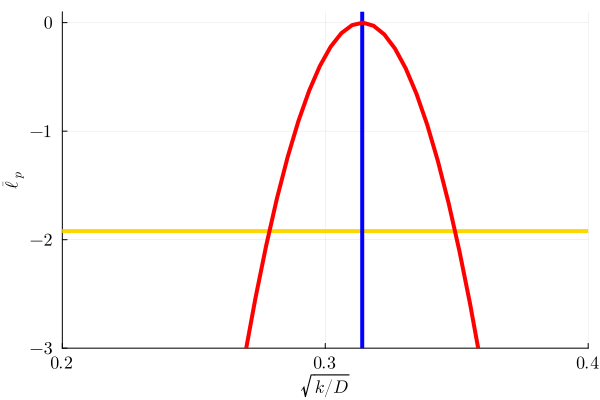

In [10]:
function univariateβ(β)
    a=zeros(1)    
    function funβ(a)
    return loglhood(data,[a[1],β],σ)
    end
    θG=[αmle]
    lb=[0.0] 
    ub=[1000.0] 
    (xopt,fopt)=Optimise(funβ,θG,lb,ub)
    return fopt,xopt
    end 
    f(x) = univariateβ(x)[1]

#Take a grid of M points to plot the univariate profile likelihood
M=50;
βrange=LinRange(0.2,0.4,M)
ff=zeros(M)
for i in 1:M
    ff[i]=univariateβ(βrange[i])[1]
end

q2=hline([llstar],legend=false,lw=4,xlabel=L"\sqrt{k/D}",ylabel=L"\bar{\ell}_p",color=:gold)
q2=vline!([βmle],legend=false,lw=4,color=:blue)
spl=Spline1D(βrange,ff.-maximum(ff),w=ones(length(βrange)),k=3,bc="nearest",s=1/100)
yy=evaluate(spl,βrange)
q2=plot!(βrange,yy,lw=4,lc=:red,ylims=(-3,0.1),xlims=(βrange[1],βrange[end]))
q2=plot!(xticks=([0.2,0.3,0.4],[L"0.2", L"0.3", L"0.4"]))
q2=plot!(yticks=([0,-1,-2,-3],[L"0", L"-1", L"-2", L"-3"]))
q2=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
display(q2)

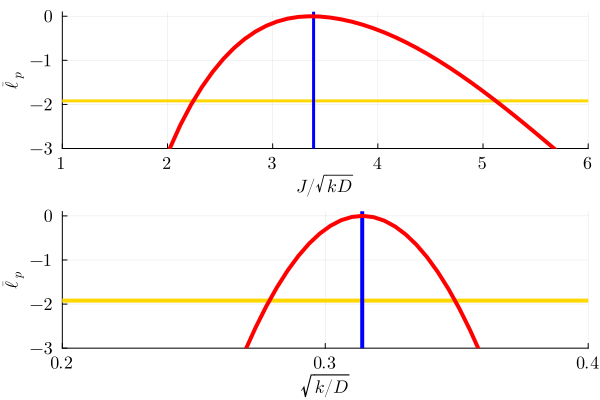

In [12]:
q3=plot(q1,q2,layout=(2,1))

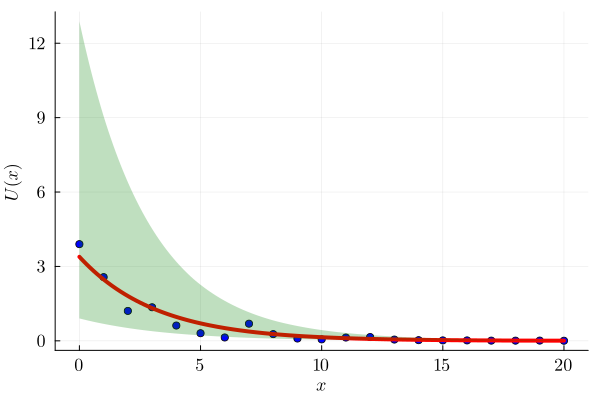

In [13]:
αmin=1;
αmax=8;
βmin=.2;
βmax=0.4;

df=2
llstar=-quantile(Chisq(df),0.95)/2
M=1000
αsampled=zeros(M)
βsampled=zeros(M)

lls=zeros(M)
global kount = 0

while kount < M
αg=rand(Uniform(αmin,αmax))
βg=rand(Uniform(βmin,βmax))
    if (loglhood(data,[αg,βg],σ)-fmle) >= llstar
     global kount+=1
    lls[kount]=loglhood(data,[αg,βg],σ)-fmle
    αsampled[kount]=αg;
    βsampled[kount]=βg;
    end
end



lower=10*ones(length(xx))
upper=zeros(length(xx))


for i in 1:M
    c(x) = αsampled[i]*exp(-x*βsampled[i]) 
     
        for j in 1:length(xx)
            if c(xx[j])*exp(quantile(Normal(0,σ),[0.05,0.95])[1]) < lower[j] 
                lower[j] = c(xx[j])*exp(quantile(Normal(0,σ),[0.05,0.95])[1])
            end
           
            if c(xx[j])*exp(quantile(Normal(0,σ),[0.05,0.95])[2]) > upper[j] 
                upper[j] = c(xx[j])*exp(quantile(Normal(0,σ),[0.05,0.95])[2])
            end
           
        end
    
    end
    

    p1=scatter(x,data,mc=:blue,msc=:match,label=false)
    p1=plot!(cmle,xx[1],xx[end],label=false,lc=:red,xlabel=L"x",ylabel=L"U(x)",xlims=(xx[1]-1,xx[end]+1),lw=4)
    p1=plot!(xticks = ([0,5,10,15,20],  [L"0", L"5", L"10", L"15", L"20"]))
    p1=plot!(yticks = ([0,3,6,9,12], [L"0", L"3", L"6", L"9", L"12"]))
    p1=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
    p1=plot!(xx,lower,lw=0,fillrange=upper,fillalpha=0.25,color=:green,label=false,xlims=(-1,xx[end]+1))
    display(p1)

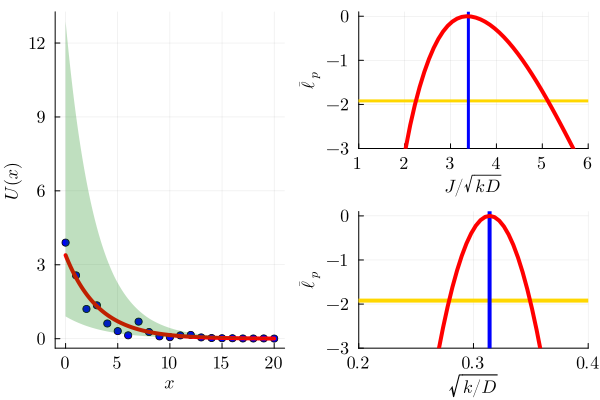

In [14]:
r1=plot(p1,q3,layout=(1,2))

In [15]:
savefig(r1,"Figure.pdf")

"C:\\Users\\matth\\Dropbox\\SIAM_Review\\Jupyter\\Figure.pdf"